# Escolha de modelos e análise de erros

Nesta fase vamos fazer o seguinte:

- Construir uma *pipeline* de processamento dos dados;
- Elencar alguns modelos a serem analisados;
- Fazer mais uma separação de dados. Desta vez vamos dividir o conjunto de treino em dois: treino e validação;
- Escolher o melhor modelo baseado no erro no conjunto de validação;
- Analisar o *resíduo*: a diferença entre o valor predito e o valor real. Será que tem algum padrão residual aqui?

Primeiro, vamos carregar os dados pré-processados:

In [1]:
from pathlib import Path

import pandas as pd
from lab01.config import DATA_DIR
from lab01.dataloader import load_preprocessed_data

In [2]:
def load_X_y(data_dir: Path) -> tuple[pd.DataFrame, pd.Series]:
    data = load_preprocessed_data(DATA_DIR)
    X = data.drop(columns=['log_median_house_value'])
    y = data['log_median_house_value']
    return X, y


X, y = load_X_y(DATA_DIR)

Vamos agora dividir os dados em treino e teste, e dividir novamente em treino (final) e validação.

In [3]:
from sklearn.model_selection import train_test_split


def split_data(
    X,
    y,
    test_size=0.25,
    random_seed=42,
) -> tuple[
        pd.DataFrame,
        pd.DataFrame,
        pd.Series,
        pd.Series,
]:
    return train_test_split(
        X,
        y,
        test_size=test_size,
        random_state=random_seed,
    )


X_train, X_test, y_train, y_test = split_data(X, y)

In [4]:
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (OneHotEncoder, PolynomialFeatures,
                                   StandardScaler)

In [5]:
geo_cols = [
    'longitude',
    'latitude',
]

numerical_cols = [
    'housing_median_age',
    'log_households',
    'log_median_income',
    'log_rooms_per_household',
    'log_population_per_household',
    'log_bedrooms_per_room',
]

categorical_cols = [
    'ocean_proximity',
]

geo_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('cluster', KMeans(n_clusters=50)),
])

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('poly', PolynomialFeatures(degree=3, include_bias=False)),
    ('scaler', StandardScaler()),
])

cat_pipeline = Pipeline([
    ('encoder', OneHotEncoder(sparse_output=False)),
])

preprocessing_pipe = ColumnTransformer(
    transformers=[
        ('geo', geo_pipeline, geo_cols),
        ('num', num_pipeline, numerical_cols),
        ('cat', cat_pipeline, categorical_cols),
    ],
    remainder='passthrough',
)

preprocessing_pipe

ColumnTransformer(remainder='passthrough',
                  transformers=[('geo',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('cluster',
                                                  KMeans(n_clusters=50))]),
                                 ['longitude', 'latitude']),
                                ('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('poly',
                                                  PolynomialFeatures(degree=3,
                                                                     include_bias=False)),
                                                 ('scaler', StandardScaler())]),
                                 ['housing_median_age', 'log_households',
                                  'log_median_income',
                                  'log_rooms_per_household',
                                  'log_population_per_household',
                                  'log_bedrooms_per_room']),
                                ('cat',
                                 Pipeline(steps=[('encoder',
                                                  OneHotEncoder(sparse_output=False))]),
                                 ['ocean_proximity'])])

## Escolha de modelos

In [6]:
from sklearn.linear_model import LinearRegression

lin_reg = Pipeline([
    ('preprocessing', preprocessing_pipe),
    ('regression', LinearRegression()),
])

In [ ]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = Pipeline([
    ('preprocessing', preprocessing_pipe),
    ('regression', DecisionTreeRegressor(random_state=42)),
])

In [8]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = Pipeline([
    ('preprocessing', preprocessing_pipe),
    (
        'regression',
        RandomForestRegressor(
            random_state=42,
            n_jobs=-1,
        ),
    ),
])

In [9]:
from sklearn.ensemble import HistGradientBoostingRegressor

hist_reg = Pipeline([
    ('preprocessing', preprocessing_pipe),
    (
        'regression',
        HistGradientBoostingRegressor(
            random_state=42,
        ),
    ),
])

In [10]:
from sklearn.ensemble import ExtraTreesRegressor

et_reg = Pipeline([
    ('preprocessing', preprocessing_pipe),
    (
        'regression',
        ExtraTreesRegressor(
            random_state=42,
            n_jobs=-1,
        ),
    ),
])

In [6]:
from sklearn.dummy import DummyRegressor

dummy_reg = Pipeline([
    ('preprocessing', preprocessing_pipe),
    (
        'regression', DummyRegressor(strategy='mean'),
    ),
])

In [12]:
from typing import Any

experiments: list[dict[str, Any]] = [
    {
        'name': 'Linear Regression',
        'model': lin_reg,
    },
    {
        'name': 'Decision Tree',
        'model': tree_reg,
    },
    {
        'name': 'Random Forest',
        'model': forest_reg
    },
    {
        'name': 'Histogram Gradient Boosting',
        'model': hist_reg,
    },
    {
        'name': 'Extra Trees',
        'model': et_reg,
    },
    {
        'name': 'Dummy',
        'model': dummy_reg,
    },    
]

#### Escolha de modelo: separação `treino_val` e `teste_val`

In [13]:
X_train_val, X_test_val, y_train_val, y_test_val = split_data(X_train, y_train)

In [ ]:
from time import perf_counter

from sklearn.metrics import root_mean_squared_error

for experiment in experiments:
    name = experiment['name']
    model = experiment['model']

    print(f'Model: {name}')
    print(f"\tTraining...")
    start_time = perf_counter()

    # Fit the model.
    model.fit(X_train_val, y_train_val)
    
    end_time = perf_counter()
    elapsed_time = end_time - start_time
    experiment['elapsed_time_training'] = elapsed_time
    print(f"\tElapsed time: {elapsed_time:.2f}s for training")

    print(f"\n\tEvaluating...")
    start_time = perf_counter()

    # Predict the training and test sets.
    y_pred_train = model.predict(X_train_val)
    y_pred_test = model.predict(X_test_val)

    end_time = perf_counter()
    elapsed_time = end_time - start_time
    experiment['elapsed_time_predict'] = elapsed_time
    print(f"\tElapsed time: {elapsed_time:.2f}s for prediction (train and test)")

    rmse_train = root_mean_squared_error(y_train_val, y_pred_train)
    rmse_test = root_mean_squared_error(y_test_val, y_pred_test)

    print(f"\n\tRMSE (train): {rmse_train:.5f}")
    print(f"\tRMSE (test): {rmse_test:.5f}")

    print("\n\n")

    experiment['rmse_train'] = rmse_train
    experiment['rmse_test'] = rmse_test

Model: Linear Regression
	Training...
	Elapsed time: 0.31s for training

	Evaluating...
	Elapsed time: 0.04s for prediction (train and test)

	RMSE (train): 0.09503
	RMSE (test): 0.10408



Model: Decision Tree
	Training...
	Elapsed time: 2.50s for training

	Evaluating...
	Elapsed time: 0.12s for prediction (train and test)

	RMSE (train): 0.00000
	RMSE (test): 0.12343



Model: Random Forest
	Training...
	Elapsed time: 11.61s for training

	Evaluating...
	Elapsed time: 0.32s for prediction (train and test)

	RMSE (train): 0.03334
	RMSE (test): 0.08807



Model: Histogram Gradient Boosting
	Training...
	Elapsed time: 0.82s for training

	Evaluating...
	Elapsed time: 0.06s for prediction (train and test)

	RMSE (train): 0.06545
	RMSE (test): 0.08466



Model: Extra Trees
	Training...
	Elapsed time: 2.38s for training

	Evaluating...
	Elapsed time: 0.23s for prediction (train and test)

	RMSE (train): 0.00000
	RMSE (test): 0.08943



Model: Dummy
	Training...
	Elapsed time: 0.08s for tr

In [15]:
results = [
    {
        'name': experiment['name'],
        'elapsed_time_training': experiment['elapsed_time_training'],
        'elapsed_time_predict': experiment['elapsed_time_predict'],
        'rmse_train': experiment['rmse_train'],
        'rmse_test': experiment['rmse_test'],
        'rmse_train_percent': 100.0 * (10.0**experiment['rmse_train'] - 1.0),
        'rmse_test_percent': 100.0 * (10.0**experiment['rmse_test'] - 1.0),
    }
    for experiment in experiments
]

results_df = pd.DataFrame(results)

In [16]:
results_df.round(4).set_index('name').transpose()

name,Linear Regression,Decision Tree,Random Forest,Histogram Gradient Boosting,Extra Trees,Dummy
elapsed_time_training,0.3054,2.4961,11.6080,0.8181,2.3755,0.0781
elapsed_time_predict,0.0378,0.1208,0.3186,0.0593,0.2267,0.0325
rmse_train,0.0950,0.0000,0.0333,0.0654,0.0000,0.2272
rmse_test,0.1041,0.1234,0.0881,0.0847,0.0894,0.2296
rmse_train_percent,24.4591,0.0000,7.9803,16.2640,0.0000,68.7355
rmse_test_percent,27.0810,32.8698,22.4805,21.5228,22.8649,69.6591


#### Escolha de modelo: Validação cruzada

In [17]:
import numpy as np
from sklearn.model_selection import cross_val_score

In [18]:
cv = 5

results = []
for experiment in experiments:
    name = experiment['name']
    model = experiment['model']

    print(f'Model: {name}')
    print(f"\tCross-validating...")
    start_time = perf_counter()

    # Faz a validação cruzada.
    scores = cross_val_score(
        model,
        X_train,
        y_train,
        scoring='neg_mean_squared_error',
        cv=cv,
    )

    end_time = perf_counter()
    elapsed_time = end_time - start_time
    print(f"\tElapsed time: {elapsed_time:.2f}s for cross-validation")

    rmse = [np.sqrt(-neg_mse) for neg_mse in scores]
    print(f"\tRMSE scores: {rmse}")
    print(f"\tMean RMSE: {np.mean(rmse):.5f}")
    print(f"\tStd RMSE: {np.std(rmse):.5f}")

    results.append(rmse)


Model: Linear Regression
	Cross-validating...
	Elapsed time: 0.54s for cross-validation
	RMSE scores: [np.float64(0.10588655915828382), np.float64(0.09700386401193538), np.float64(0.09804353211542596), np.float64(0.09932867731816826), np.float64(0.09562704319065522)]
	Mean RMSE: 0.09918
	Std RMSE: 0.00357
Model: Decision Tree
	Cross-validating...
	Elapsed time: 14.15s for cross-validation
	RMSE scores: [np.float64(0.1261224981141256), np.float64(0.12697127625937368), np.float64(0.12829398699893987), np.float64(0.12514234917587627), np.float64(0.12522090935870908)]
	Mean RMSE: 0.12635
	Std RMSE: 0.00118
Model: Random Forest
	Cross-validating...
	Elapsed time: 66.29s for cross-validation
	RMSE scores: [np.float64(0.09082452066131586), np.float64(0.08658417052315148), np.float64(0.0866028884238685), np.float64(0.08704428229260697), np.float64(0.08582423934128192)]
	Mean RMSE: 0.08738
	Std RMSE: 0.00177
Model: Histogram Gradient Boosting
	Cross-validating...
	Elapsed time: 4.33s for cross-

In [19]:
results = 100*(10**np.array(results)  - 1)

In [20]:
results_df = pd.DataFrame(
    results.T,
    columns=[experiment['name'] for experiment in experiments],
)

In [21]:
results_df

,Linear Regression,Decision Tree,Random Forest,Histogram Gradient Boosting,Extra Trees,Dummy
0,27.610544,33.697257,23.260669,22.469966,23.763100,69.180556
1,25.027015,33.958809,22.063037,21.309090,22.645225,69.855782
2,25.326679,34.367423,22.068298,21.164469,22.611222,68.412100
3,25.698090,33.395859,22.192425,21.392899,22.742754,69.593315
4,24.631277,33.419992,21.849637,21.807136,22.425378,67.834872


In [29]:
results_df.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
Linear Regression,5.0,25.66,1.16,24.63,25.03,25.33,25.70,27.61
Decision Tree,5.0,33.77,0.41,33.40,33.42,33.70,33.96,34.37
Random Forest,5.0,22.29,0.56,21.85,22.06,22.07,22.19,23.26
Histogram Gradient Boosting,5.0,21.63,0.53,21.16,21.31,21.39,21.81,22.47
Extra Trees,5.0,22.84,0.53,22.43,22.61,22.65,22.74,23.76
Dummy,5.0,68.98,0.84,67.83,68.41,69.18,69.59,69.86


### Escolha de modelo: ajuste de *hiperparâmetros*

In [30]:
from sklearn.dummy import DummyRegressor

pipe = Pipeline([
    ('preprocessing', preprocessing_pipe),
    ('regression', DummyRegressor(strategy='mean')),
])

In [43]:
param_grid = [
    {
        'regression': [DummyRegressor()],
        'regression__strategy': ['mean', 'median'],
    },
    {
        'regression': [DecisionTreeRegressor()],
        'regression__max_depth': [1, 2, 5, 10, 20, 50, 100, None],
        'regression__min_samples_split': [2, 5, 10],
        'preprocessing__num__poly__degree': [1, 2, 3],
        'preprocessing__geo__cluster__n_clusters': [10, 20, 50, 100],
    }
]

In [44]:
from sklearn.model_selection import GridSearchCV

cv = 5

grid_search = GridSearchCV(
    pipe,
    param_grid,
    cv=cv,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
)

grid_search

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('geo',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('cluster',
                                                                                          KMeans(n_clusters=50))]),
                                                                         ['longitude',
                                                                          'latitude']),
                                                                        ('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('poly',
                                                                                          PolynomialFeatures(degree=3...
             param_grid=[{'regression': [DummyRegressor()],
                          'regression__strategy': ['mean', 'median']},
                         {'preprocessing__geo__cluster__n_clusters': [10, 20,
                                                                      50, 100],
                          'preprocessing__num__poly__degree': [1, 2, 3],
                          'regression': [DecisionTreeRegressor()],
                          'regression__max_depth': [1, 2, 5, 10, 20, 50, 100,
                                                    None],
                          'regression__min_samples_split': [2, 5, 10]}],
             scoring='neg_mean_squared_error')

In [7]:
from sklearn.linear_model import LinearRegression

lin_reg = Pipeline([
    ('preprocessing', preprocessing_pipe),
    ('regression', LinearRegression()),
])

In [8]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = Pipeline([
    ('preprocessing', preprocessing_pipe),
    ('regression', DecisionTreeRegressor(random_state=42)),
])

In [9]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = Pipeline([
    ('preprocessing', preprocessing_pipe),
    (
        'regression',
        RandomForestRegressor(
            random_state=42,
            n_jobs=-1,
        ),
    ),
])

In [10]:
from sklearn.ensemble import HistGradientBoostingRegressor

hist_reg = Pipeline([
    ('preprocessing', preprocessing_pipe),
    (
        'regression',
        HistGradientBoostingRegressor(
            random_state=42,
        ),
    ),
])

In [11]:
from sklearn.ensemble import ExtraTreesRegressor

et_reg = Pipeline([
    ('preprocessing', preprocessing_pipe),
    (
        'regression',
        ExtraTreesRegressor(
            random_state=42,
            n_jobs=-1,
        ),
    ),
])

In [12]:
from typing import Any

experiments: list[dict[str, Any]] = [
    {
        'name': 'Linear Regression',
        'model': lin_reg,
    },
    {
        'name': 'Decision Tree',
        'model': tree_reg,
    },
    {
        'name': 'Random Forest',
        'model': forest_reg
    },
    {
        'name': 'Histogram Gradient Boosting',
        'model': hist_reg,
    },
    {
        'name': 'Extra Trees',
        'model': et_reg,
    },
]

In [13]:
import numpy as np
from sklearn.base import BaseEstimator
from sklearn.metrics import root_mean_squared_error


def train_and_evaluate_model(
    model: BaseEstimator,
    X_train: pd.DataFrame,
    y_train: np.array,
    X_test: pd.DataFrame,
    y_test: np.array,
) -> float:
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    rmse_train = root_mean_squared_error(y_train, y_train_pred)
    rmse_test = root_mean_squared_error(y_test, y_test_pred)

    return rmse_train, rmse_test

In [14]:
from collections import defaultdict
from time import perf_counter

results = defaultdict(list)

for experiment in experiments:
    name = experiment['name']
    model = experiment['model']

    print(f'Running experiment: {name}')

    start_time = perf_counter()
    rmse_train, rmse_test = train_and_evaluate_model(
        model,
        X_train_val,
        y_train_val,
        X_test_val,
        y_test_val,
    )
    end_time = perf_counter()
    elapsed_time = end_time - start_time
    
    percentage_error_train = 100.0 * (10.0**rmse_train - 1.0)
    percentage_error_test = 100.0 * (10.0**rmse_test - 1.0)

    experiment['rmse_train'] = rmse_train
    experiment['rmse_test'] = rmse_test

    results['name'].append(name)
    results['rmse_train'].append(rmse_train)
    results['rmse_test'].append(rmse_test)
    results['percentage_error_train'].append(percentage_error_train)
    results['percentage_error_test'].append(percentage_error_test)
    results['elapsed_time_seconds'].append(elapsed_time)

print('Done!')

Running experiment: Linear Regression
Running experiment: Decision Tree
Running experiment: Random Forest
Running experiment: Histogram Gradient Boosting
Running experiment: Extra Trees
Done!


In [15]:
grid_search.fit(X_train, y_train)

,name,rmse_train,rmse_test,percentage_error_train,percentage_error_test,elapsed_time_seconds
0,Linear Regression,0.10,0.10,24.63,27.07,0.15
1,Decision Tree,0.00,0.12,0.00,32.89,1.19
2,Random Forest,0.03,0.09,7.90,22.32,11.91
3,Histogram Gradient Boosting,0.07,0.08,16.30,21.53,1.20
4,Extra Trees,0.00,0.09,0.00,22.78,3.20


In [16]:
best_model = min(experiments, key=lambda x: x['rmse_test'])
print(f'\nBest model: {best_model["name"]}')


Best model: Histogram Gradient Boosting


In [17]:
model = best_model['model']

model.fit(X_train_val, y_train_val)

y_train_pred = model.predict(X_train_val)
y_test_pred = model.predict(X_test_val)

rmse_train = root_mean_squared_error(y_train_val, y_train_pred)
rmse_test = root_mean_squared_error(y_test_val, y_test_pred)

print(f'\nTraining RMSE: {rmse_train:.4f}')
print(f'Test RMSE: {rmse_test:.4f}')


Training RMSE: 0.0654
Test RMSE: 0.0846


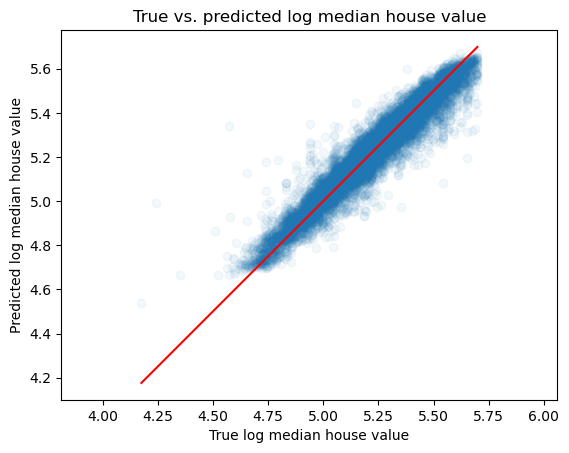

In [18]:
grid_search.best_params_

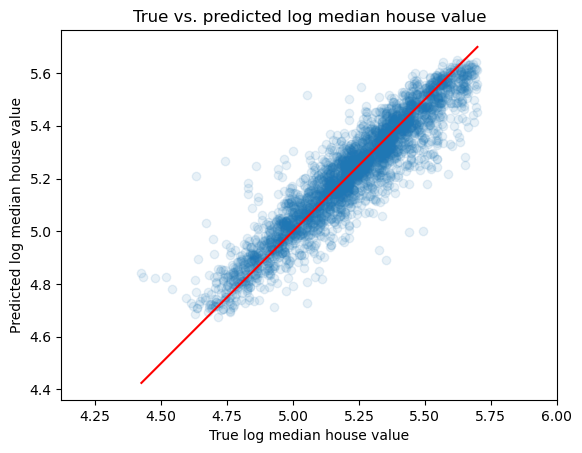

In [19]:
100*(10**np.sqrt(-grid_search.best_score_) - 1)

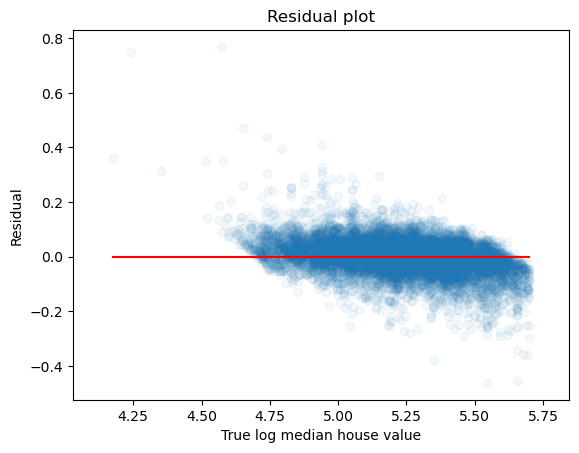

In [20]:
import matplotlib.pyplot as plt

plt.scatter(y_train_val, y_train_pred - y_train_val, alpha=0.05)
plt.plot([min(y_train_val), max(y_train_val)], [0, 0], color='red')
plt.xlabel('True log median house value')
plt.ylabel('Residual')
plt.title('Residual plot')
plt.axis('equal')
plt.show()

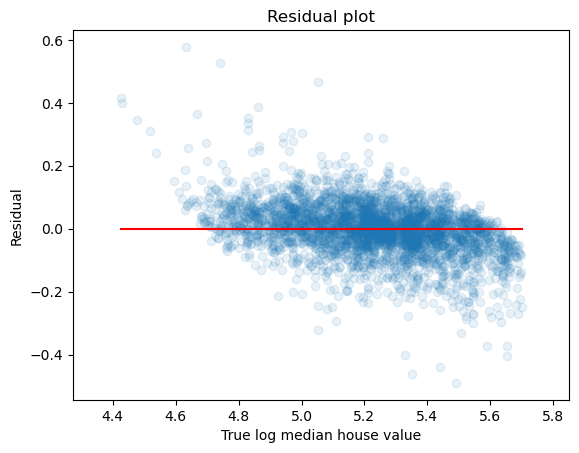

In [21]:
import matplotlib.pyplot as plt

plt.scatter(y_test_val, y_test_pred - y_test_val, alpha=0.1)
plt.plot([min(y_test_val), max(y_test_val)], [0, 0], color='red')
plt.xlabel('True log median house value')
plt.ylabel('Residual')
plt.title('Residual plot')
plt.axis('equal')
plt.show()

## Avaliação